In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [67]:
# gradient of y wrt w given x, activations, and C
# There are M training examples and N features (including bias)
# x is MxN
# y is Mx1
# w is Nx1
# activations is Mx1
# C is scalar
# Returns Nx1 column of gradients
def get_gradient(x, y, w, activations, C):
    values = -1 * x * y # MxN
    mask = (activations[:, 0] == 0.0)
    values[mask, :] = 0
    avg = np.mean(values, axis=0, keepdims=True)
    return C*avg.T + w

# x is MxN
# y is Mx1
# w is Nx1
# Returns Mx1 column of activations
def get_activations(x, y, w):
    #print "x", x.shape
    #print "y", y.shape
    #print "w", w.shape
    return np.maximum(0, 1 - (y * np.matmul(x, w)))

# w is Nx1
# activations is Mx1
# C is scalar
# Returns a scalar
def get_cost(w, activations, C):
    regularizer = 0.5 * np.sum(np.square(w))
    return C * np.mean(activations) + regularizer

# x is MxN
# y is Mx1
# w is Nx1
# C is scalar
# Returns scalar cost and Nx1 column of gradients
def get_cost_and_gradient(x, y, w, C):
    activations = get_activations(x, y, w)
    cost = get_cost(w, activations, C)
    gradient = get_gradient(x, y, w, activations, C)
    return (cost, gradient)

# x is MxN
# y is Mx1
# w is Nx1
# C is scalar
# Returns current cost, new w
def training_step(x, y, w, C, learning_rate):
    (cost, gradient) = get_cost_and_gradient(x, y, w, C)
    step = -1 * learning_rate * gradient
    return (cost, w + step)

def train_loop(x, y, test_x, test_y, C, learning_rate, batch_size, epochs):
    # Lists of stuff, which are global
    global loss, test_loss, params
    loss = []
    test_loss = []
    params = []
    
    (M, N) = x.shape
    assert y.shape == (M, 1)
    (M_test, N_test) = test_x.shape
    assert N_test == N
    assert test_y.shape == (M_test, 1)

    # Intialize weights
    w = np.random.normal(size=(N+1, 1))
    # Add 1s to x for bias term
    x = np.append(x, np.ones((M, 1)), axis=1)
    test_x = np.append(test_x, np.ones((M_test, 1)), axis=1)

    # Run training
    for e in xrange(epochs):
        for i in xrange(0, M, batch_size):
            (cost, w) = training_step(
                x[i:i+batch_size], y[i:i+batch_size], w, C, learning_rate)
            step = i / batch_size
            if step % 50 == 0:
                (test_cost, _) = get_cost_and_gradient(
                    test_x[i:i+batch_size], test_y[i:i+batch_size], w, C)
                #print "Epoch %d, step %d, training loss %f, test loss %f" % (
                #    e, step, cost, test_cost)
                loss.append(cost)
                test_loss.append(test_cost)
                params.append(w)
        (test_cost, _) = get_cost_and_gradient(
            test_x[i:i+batch_size], test_y[i:i+batch_size], w, C)
        #print "End of epoch %d, training loss %f, test loss %f" % (step, cost, test_cost)

    # Return final params
    return w

def multiclass_train_loop(x, y, test_x, test_y, C, learning_rate, batch_size, epochs):
    global loss, test_loss, params
    global cat_loss, cat_test_loss, cat_params
    cat_loss = []
    cat_test_loss = []
    cat_params = []
    cat_w = []
    
    np.random.seed(31415) # repeatability

    L = y.shape[1]
    (M, N) = x.shape
    assert y.shape == (M, L)
    (M_test, N_test) = test_x.shape
    assert N_test == N
    assert test_y.shape == (M_test, L)

    for label in xrange(L):
        #print "Starting label", label
        # Find all positive examples, create +1 labels
        positive_examples = x[y[:, label] == 1, :]
        #print "POSITIVE"
        #print positive_examples
        num_positive_examples = positive_examples.shape[0]
        positive_labels = np.full((num_positive_examples, 1), 1, dtype='int32')

        # Find all negative examples, create -1 labels
        negative_examples = x[y[:, label] != 1, :]
        num_negative_examples = negative_examples.shape[0]
        #assert num_negative_examples >= num_positive_examples
        #print "NEGATIVE"
        #print negative_examples

        # Subsample negative examples
        #sample = np.random.permutation(num_negative_examples)[:num_positive_examples]
        #negative_sample = negative_examples[sample, :]
        #negative_labels = np.full((num_positive_examples, 1), -1, dtype='int32')

        negative_labels = np.full((num_negative_examples, 1), -1, dtype='int32')

        
        # Create shuffled training input to classifier
        all_x = np.vstack([positive_examples, negative_examples])
        all_y = np.vstack([positive_labels, negative_labels])
        shuffle = np.random.permutation(all_x.shape[0])
        all_x = all_x[shuffle]
        all_y = all_y[shuffle]
        #print "TRAIN"
        #print np.hstack([all_x, all_y])

        # Binarize test set labels
        test_labels = np.ones((len(test_y), 1))
        test_labels[test_y[:, label] != 1, :] = -1

        # Run training
        w = train_loop(all_x, all_y, test_x, test_labels, C, learning_rate, batch_size, epochs)

        # Store results for this category
        cat_loss.append(loss)
        cat_test_loss.append(test_loss)
        cat_params.append(params)
        cat_w.append(w)

    # Return per-parameter weights
    return np.hstack(cat_w)

# x is MxN
# ws is NxL (if there are L classes)
# Returns array of size M, where each entry is index of predicted class
def get_multiclass_predictions(x, ws):
    # Add 1s to x for bias term
    M = x.shape[0]
    x = np.append(x, np.ones((M, 1)), axis=1)
    values = np.matmul(x, ws)
    predictions = np.argmax(values, axis=1)
    return predictions

In [28]:
data = np.array([[-4, 10],
                 [1, 10],
                 [-6, 8],
                 [-3, 8],
                 [3, 8],
                 [-1, 7],
                 [-4, 5],
                 [0, 5],
                 [-6, 3],
                 [-2, 2],
                 [-6, 1],
                 [-5, -1],
                 [-7, -2],
                 [-6, -4],
                 
                 [-1, -2],
                 [-4, -5],
                 [-1, -5],
                 [1, -5],
                 [-6, -7],
                 [-2, -7],
                 [1, -7],
                 [3, -7],
                 [-4, -8],
                 [1, -9],
                 [5, -9],
                 [-7, -10],
                 [-4, -10],
                 [-2, -10],
                 
                 [7, 10],
                 [6, 7],
                 [7, 6],
                 [3, 5],
                 [5, 4],
                 [7, 3],
                 [2, 2],
                 [5, 2],
                 [5, 0],
                 [2, -1],
                 [7, -1],
                 [5, -2],
                 [5, -4],
                 [7, -6]])                 

In [11]:
labels = np.array([[1, 0, 0]]*14 + [[0, 1, 0]]*14 + [[0, 0, 1]]*14)

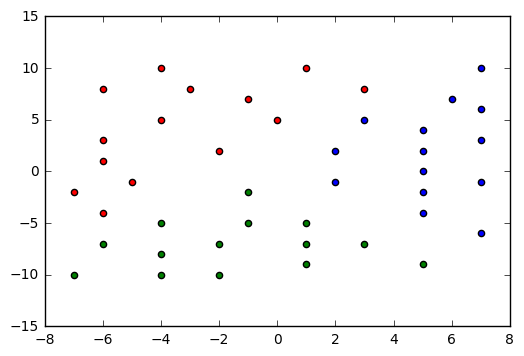

In [32]:
plt.scatter(data[:14,0], data[:14,1], c='r')
plt.scatter(data[14:28,0], data[14:28,1], c='g')
plt.scatter(data[28:,0], data[28:,1], c='b')

[[-0.54975171 -0.06136595  0.39465926]
 [ 0.42182046 -0.29361379  0.06494681]
 [-0.7268056  -0.87686927 -0.86309866]]


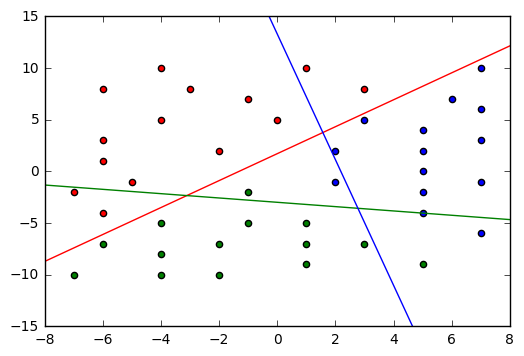

In [90]:
C = 10
learning_rate = 0.003
batch_size = 2800
epochs = 1000
ws = multiclass_train_loop(data, labels, data, labels, C, learning_rate, batch_size, epochs)
print ws

predictions = get_multiclass_predictions(data, ws)
actual = np.argmax(labels, axis=1)
correct = np.equal(predictions, actual)

mask = np.logical_and(correct, np.equal(actual, 0))
plt.scatter(data[mask, 0], data[mask,1], c='r')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 0))
plt.scatter(data[mask, 0], data[mask,1], c='r', marker='+')

mask = np.logical_and(correct, np.equal(actual, 1))
plt.scatter(data[mask, 0], data[mask,1], c='g')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 1))
plt.scatter(data[mask, 0], data[mask,1], c='g', marker='+')

mask = np.logical_and(correct, np.equal(actual, 2))
plt.scatter(data[mask, 0], data[mask,1], c='b')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 2))
plt.scatter(data[mask, 0], data[mask,1], c='b', marker='+')

plt.axis((-8, 8, -15, 15))

a, b, c = ws[:, 0]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='r')

a, b, c = ws[:, 1]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='g')

a, b, c = ws[:, 2]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='b')

In [82]:
np.vstack([get_multiclass_predictions(data, ws),
           np.argmax(labels, axis=1)]).T

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2]])

In [23]:
import classifier_utils as utils
reload(utils)

<module 'classifier_utils' from 'classifier_utils.py'>

In [24]:
# Dataset
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]
train, test = utils.get_augmented_dataset(categories)

Dropped 2082 patches because too close to image border


In [5]:
import cv2

In [6]:
# HOG Descriptors
winSize = (32, 32)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

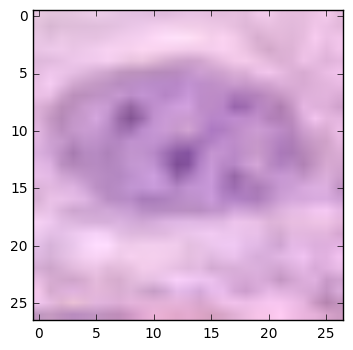

In [7]:
plt.imshow(patches[0])

In [20]:
#plt.imshow()
big = cv2.resize(patches[0], (32, 32), interpolation=cv2.INTER_LINEAR)
hist1 = hog.compute(big)
gray = cv2.cvtColor(big, cv2.COLOR_BGR2GRAY)
hist2 = hog.compute(gray)#, padding=(0,0), locations=[(0,0)], winStride=(8,8))
hist2.shape

(324, 1)

In [13]:
#np.hstack([hist1, hist2])